## PyTorch Computer Vision

There are four primary types of problems in computer vision.  
In binary and multiclass classification, a model is trained to classify images.  
In object detection, a model determines whether a particular object is present in a given image or not.  
Image segmentation involves partitioning an image into multiple image segments.

## Computer vision libraries in PyTorch

`torchvision.datasets` contains example computer vision datasets for all kinds of problems.  
`torchvision.models` contains well-performing and commonly-used computer vision architectures.  
`torchvision.transforms` contain common image transformations.  
`torch.utils.data.Dataset` is the base dataset class in PyTorch.  
`torch.utils.data.DataLoader` creates an interable over a `torch.utils.data.Dataset`.

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Getting a dataset

The `root` attribute determines the folder in which the data should be saved.  
The `download` attribute is set to `True` if we want the data to be saved.  
The `ToTensor()` method converts PIL images to PyTorch tensors.  
The `target_transform` attribute is used for applying transformations on output labels.

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [4]:
class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


The training data is in NCHW format - N is the number of images, C is the number of color channels, H is the height, and W is the width.  
As a result, the tensor for each induvidual image is in CHW format.
The NHWC format, where color channels come in the end, is said to perform better and is considered best practice.

Text(0.5, 1.0, 'Ankle boot')

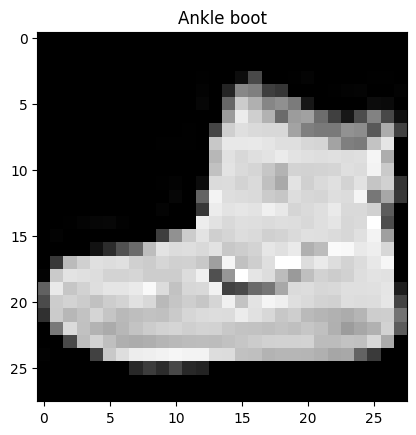

In [5]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

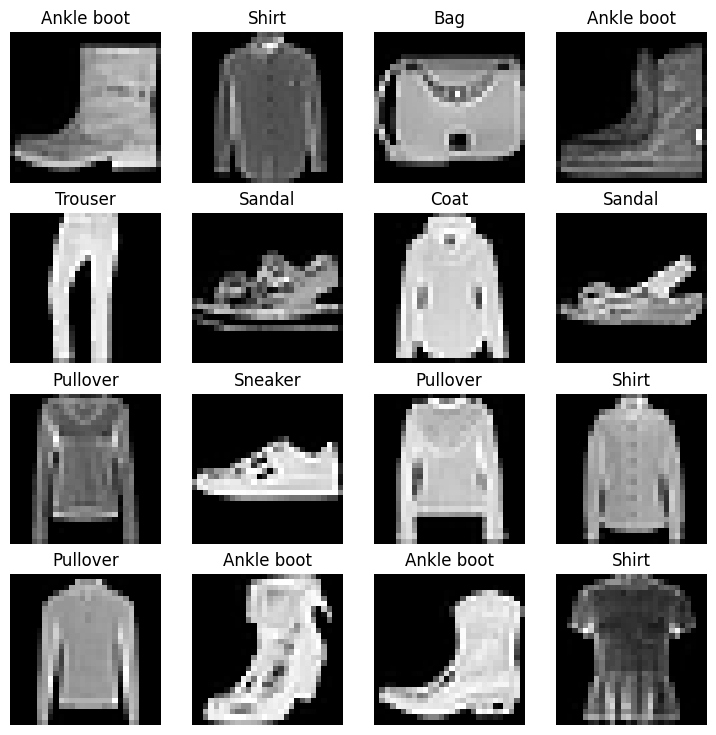

In [6]:
torch.manual_seed(42)
rows, cols = 4, 4
fig = plt.figure(figsize=(9, 9))
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Preparing the Dataloader

`DataLoader` has the ability to divide data into batches, the size of which can be set using the `batch_size` attribute.  
The batch size, which is a hyderparameter, is generally set to `32`, and other values it can be set to are `64`, `128`, `256`, and `512`.  
The `shuffle` attribute is set to `True` if we want the data to be shuffled across batches after every epoch; by convention the training data is shuffled but the testing data is not.

In [7]:
from torch.utils.data import DataLoader

In [8]:
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print(len(train_dataloader), len(test_dataloader))

1875 313


## Building the baseline model

A baseline model is a simple model which acts as a starting point upon which more complicated models are built.
The `Flatten` layer converts the shape of the image data from `[1, 28, 28]` to `[1, 784]`.  
The first dimension of size `1` is retained as it represents the size of a batch in this context.

In [9]:
class FashionModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

In [10]:
torch.manual_seed(42)
model = FashionModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))
model.to("cpu")

FashionModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [11]:
import requests
from pathlib import Path

In [12]:
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [13]:
from helper_functions import accuracy_fn

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

`timer` is used for measuing total training time.  
`tqdm` is used for displaying a progress bar.

In [15]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

In [16]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n--------")
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.2f} | Test accuracy: {test_acc:.2f}%\n")
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.51 | Test accuracy: 82.04%

Epoch: 1
--------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.48 | Test accuracy: 83.20%

Epoch: 2
--------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.48 | Test accuracy: 83.43%

Total training time: 24.495 seconds


## Evaluating performance

In [17]:
def eval_model(model: nn.Module, data_loader: DataLoader, loss_fn: nn.Module, accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        'model_name': model.__class__.__name__,
        'model_loss': loss.item(),
        'model_acc': acc
    }

In [18]:
model_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)
model_results

{'model_name': 'FashionModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

model_results = eval_model(model, test_dataloader, nn.CrossEntropyLoss(), accuracy_fn)
model_results

## Model with non-linearity

In [19]:
class FashionModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

The `next()` function returns the next element of an iterable.

In [20]:
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FashionModelV1(784, 10, len(class_names)).to(device)
next(model.parameters()).device

device(type='cpu')

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [22]:
def train_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, accuracy_fn, device: torch.device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [23]:
def test_step(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, accuracy_fn, device: torch.device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [24]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

Epoch: 0
--------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
--------
Train loss: 0.78097 | Train accuracy: 71.94%
Test loss: 0.72611 | Test accuracy: 73.99%

Epoch: 2
--------
Train loss: 0.67040 | Train accuracy: 75.94%
Test loss: 0.69007 | Test accuracy: 74.81%

Total training time: 24.873 seconds


In [25]:
model_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)
model_results

{'model_name': 'FashionModelV1',
 'model_loss': 0.6900655031204224,
 'model_acc': 74.810303514377}

## Convolutional Neural Network

A CNN typically consists of three layers sandwiched between the input and output layers - a convolutional layer, an activation layer, and a pooling layer.  
These layers can be repeated multiple times depending on the requirements.  
CNNs (and transformers) are used for unstructured data, such as images, audio, and language.  
For structured data, such as data in rows and columns, gradient boosted models, random forests, and XGBoosts are used.

`nn.Conv2d` creates a convolutional layer.  
`in_channels` and `out_channels` set the number of input and output channels respectively.  
`kernel_size` (`int` or `tuple`) describes the size of the kernel.  
`stride` (`int` or `tuple`) describes the size of the step taken by the convoluting kernel (the default value is `1`).  
`padding` sets the number of pixels padded to each side of the image (the default value is `0`).

`nn.MaxPool2d` creates a max pool layer.  
A max pool layer maps each kernel grid to its maximum value.

In [26]:
class FashionModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*49, output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [27]:
model = FashionModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
model

FashionModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Both `nn.Conv2d` and `nn.MaxPool2d` input and output data of dimensions `(N, C, H, W)`.  
Therefore, a single image of dimensions `(C, H, W)` has to be unsqueezed to dimensions `(1, C, H, W)` before passing it through these layers.

In [28]:
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]
print(test_image.shape)
test_image = test_image.unsqueeze(dim=0)
print(test_image.shape)
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
test_image = conv_layer(test_image)
print(test_image.shape)
max_pool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
test_image = max_pool_layer(test_image)
print(test_image.shape)

torch.Size([3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 62, 62])
torch.Size([1, 10, 31, 31])


In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [30]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n--------")
    train_step(model=model, data_loader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
    test_step(model=model, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
end_time = timer()
print(f"Total training time: {(end_time - start_time):.3f} seconds")

Epoch: 0
--------
Train loss: 0.58689 | Train accuracy: 78.64%
Test loss: 0.39822 | Test accuracy: 85.65%

Epoch: 1
--------
Train loss: 0.35719 | Train accuracy: 87.02%
Test loss: 0.35158 | Test accuracy: 87.27%

Epoch: 2
--------
Train loss: 0.32194 | Train accuracy: 88.31%
Test loss: 0.31907 | Test accuracy: 88.49%

Total training time: 117.923 seconds


In [31]:
model_results = eval_model(model, test_dataloader, loss_fn, accuracy_fn)
model_results

{'model_name': 'FashionModelV2',
 'model_loss': 0.319065123796463,
 'model_acc': 88.48841853035144}

In [32]:
def make_predictions(model: nn.Module, data: list, device: torch.device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [33]:
import random

In [34]:
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)
pred_probs = make_predictions(model, test_samples, device)
pred_classes = pred_probs.argmax(dim=1)

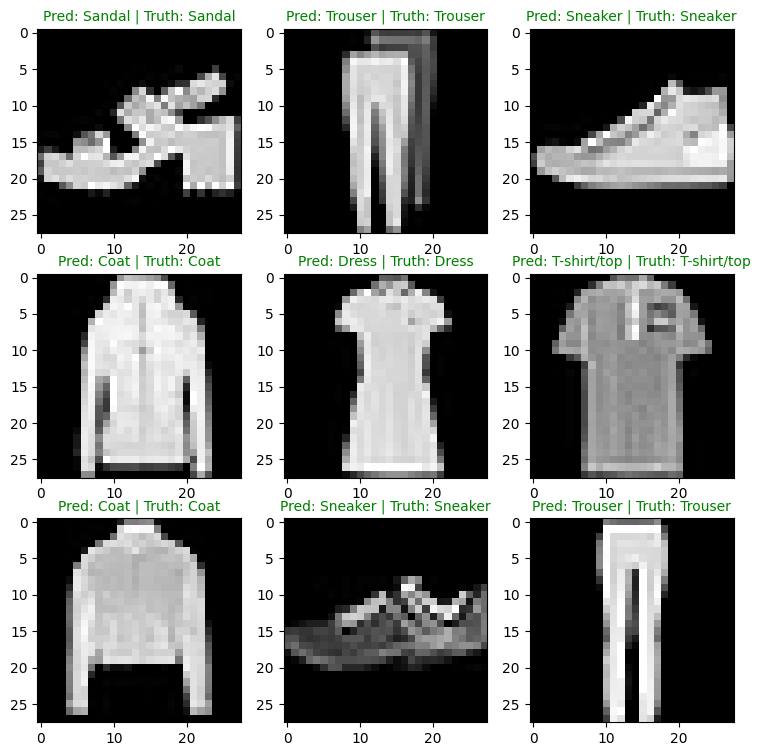

In [35]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")

## Creating a confusion matrix

In [36]:
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred)
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

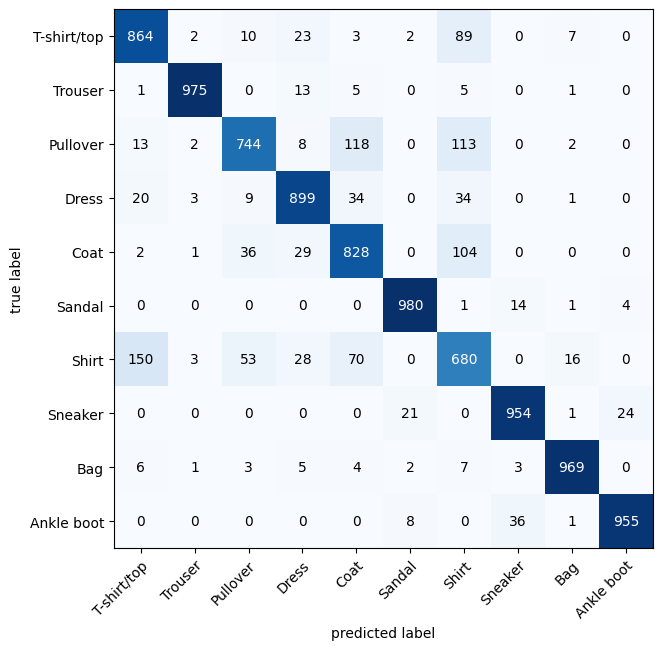

In [38]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## Saving the model

In [39]:
from pathlib import Path

In [40]:
MODEL_PATH = Path('models')
MODEL_NAME = "03_computer_vision_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/03_computer_vision_model.pth
